## Análise Exploratória de Dados - IMBD

## Instalando e Carregando Pacotes

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.8


https://pypi.org/

https://pypi.org/project/imdb-sqlite/

In [ ]:
# Instala o pacote
!pip install -q imdb-sqlite

Agora executamos o pacote para download dos datasets.

In [ ]:
# Instala o pacote
# https://pypi.org/project/pycountry/
!pip install -q pycountry

In [ ]:
# Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando os Dados

Fazendo download dos dados diretamente da lib

In [ ]:
%%time
!imdb-sqlite

Wall time: 22min 55s


2023-01-15 13:13:42,260 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads\name.basics.tsv.gz
2023-01-15 13:14:00,478 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads\title.basics.tsv.gz
2023-01-15 13:14:13,199 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads\title.akas.tsv.gz
2023-01-15 13:14:35,778 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads\title.principals.tsv.gz
2023-01-15 13:15:08,455 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads\title.episode.tsv.gz
2023-01-15 13:15:11,452 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads\title.ratings.tsv.gz
2023-01-15 13:15:11,956 Populating database: imdb.db
2023-01-15 13:15:11,957 Applying schema
2023-01-15 13:15:11,968 Importing file: downloads\name.basics.tsv.gz
2023-01-15 13:15:11,968 Reading number of rows ...
2023-01-15 13:15:16,330 Inserting rows into table: people

100%|##########| 12227928/12227928 [01:45<00:00, 116259.53 rows/s]
2

In [ ]:
# Conectando no banco de dados
conn = sqlite3.connect("imdb.db")

In [ ]:
# Extrair a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [ ]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [ ]:
# Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [ ]:
# Converter o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [ ]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,VARCHAR,0,None,0
1,1,show_title_id,VARCHAR,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




> Agora começamos a Análise Exploratória dos Dados.

## 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos (filmes)?

In [ ]:
# Criar a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type''' 

In [ ]:
# Extrair o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [ ]:
# Visualizar o resultado
display(resultado1)

,type,COUNT
0,movie,632244
1,short,908413
2,tvEpisode,7208858
3,tvMiniSeries,46778
4,tvMovie,139967
5,tvPilot,2
6,tvSeries,236873
7,tvShort,9887
8,tvSpecial,40110
9,video,269331


In [ ]:
#Calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [ ]:
#Visualizar o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,632244,6.637214
1,short,908413,9.536399
2,tvEpisode,7208858,75.677637
3,tvMiniSeries,46778,0.491069
4,tvMovie,139967,1.469355
5,tvPilot,2,0.000021
6,tvSeries,236873,2.486661
7,tvShort,9887,0.103792
8,tvSpecial,40110,0.421069
9,video,269331,2.827401


In [ ]:
# Gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restante

others = {}

# Filtrar o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Gravar o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajustar o nome
others['type'] = 'others'

In [ ]:
others

{'COUNT': 776229, 'percentual': 8.148749326036896, 'type': 'others'}

In [ ]:
# Filtrando o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [ ]:
# Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [ ]:
# Ordenando o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [ ]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,7208858,75.677637
1,short,908413,9.536399
3,others,776229,8.148749
0,movie,632244,6.637214


In [ ]:
# Ajustar os labels
labels = [str(resultado1['type'][i]) + ' ' + '[' + str(round(resultado1['percentual'][i],2)) + '%' + ']' for i in resultado1.index]

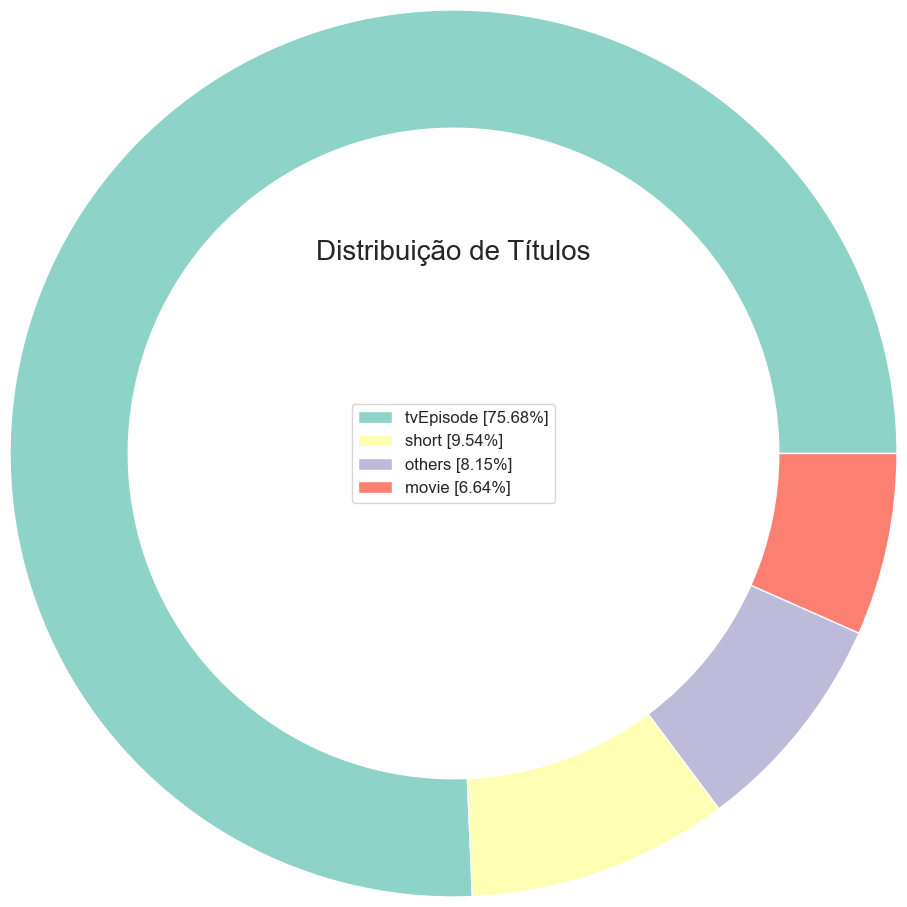

In [ ]:
# Plot

# Mapa de cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## 2- Qual o Número de Títulos Por Gênero?

Calcular o número de filmes por gênero e entregar o resultado em valor percentual.

In [ ]:
# CriaR a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 

In [ ]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [ ]:
display(resultado2)

,genres,COUNT(*)
0,None,71652
1,Action,14419
2,"Action,Adult",11
3,"Action,Adult,Adventure",2
4,"Action,Adult,Comedy",5
...,...,...
1471,"Thriller,War,Western",3
1472,"Thriller,Western",42
1473,War,1315
1474,"War,Western",15


In [ ]:
# Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [ ]:
# Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

1                       action
2                 action,adult
3       action,adult,adventure
4          action,adult,comedy
5           action,adult,crime
                 ...          
1471      thriller,war,western
1472          thriller,western
1473                       war
1474               war,western
1475                   western
Name: genres, Length: 1475, dtype: object

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero.

![title](imagens/one-hot.png)

In [ ]:
# criar um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [ ]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [ ]:
# Aplicar a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [ ]:
type(bag_generos)

scipy.sparse._csr.csr_matrix

In [ ]:
# Retornar gêneros únicos
generos_unicos =  vetor.get_feature_names()

In [ ]:
# Criar o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [ ]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475 entries, 1 to 1475
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   action        1475 non-null   int64
 1   adult         1475 non-null   int64
 2   adventure     1475 non-null   int64
 3   animation     1475 non-null   int64
 4   biography     1475 non-null   int64
 5   comedy        1475 non-null   int64
 6   crime         1475 non-null   int64
 7   documentary   1475 non-null   int64
 8   drama         1475 non-null   int64
 9   experimental  1475 non-null   int64
 10  family        1475 non-null   int64
 11  fantasy       1475 non-null   int64
 12  film-noir     1475 non-null   int64
 13  game-show     1475 non-null   int64
 14  history       1475 non-null   int64
 15  horror        1475 non-null   int64
 16  music         1475 non-null   int64
 17  musical       1475 non-null   int64
 18  mystery       1475 non-null   int64
 19  news          1475 non-null

In [ ]:
# Drop da coluna "n"
generos = generos.drop(columns = 'n', axis = 0)

KeyError: "['n'] not found in axis"

In [ ]:
# Calcular o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [ ]:
generos_percentual.head(10)

drama          17.898305
comedy         16.813559
documentary    15.932203
adventure      14.508475
action         14.372881
romance        13.220339
crime          13.084746
fantasy        12.338983
mystery        12.338983
thriller       12.271186
dtype: float64

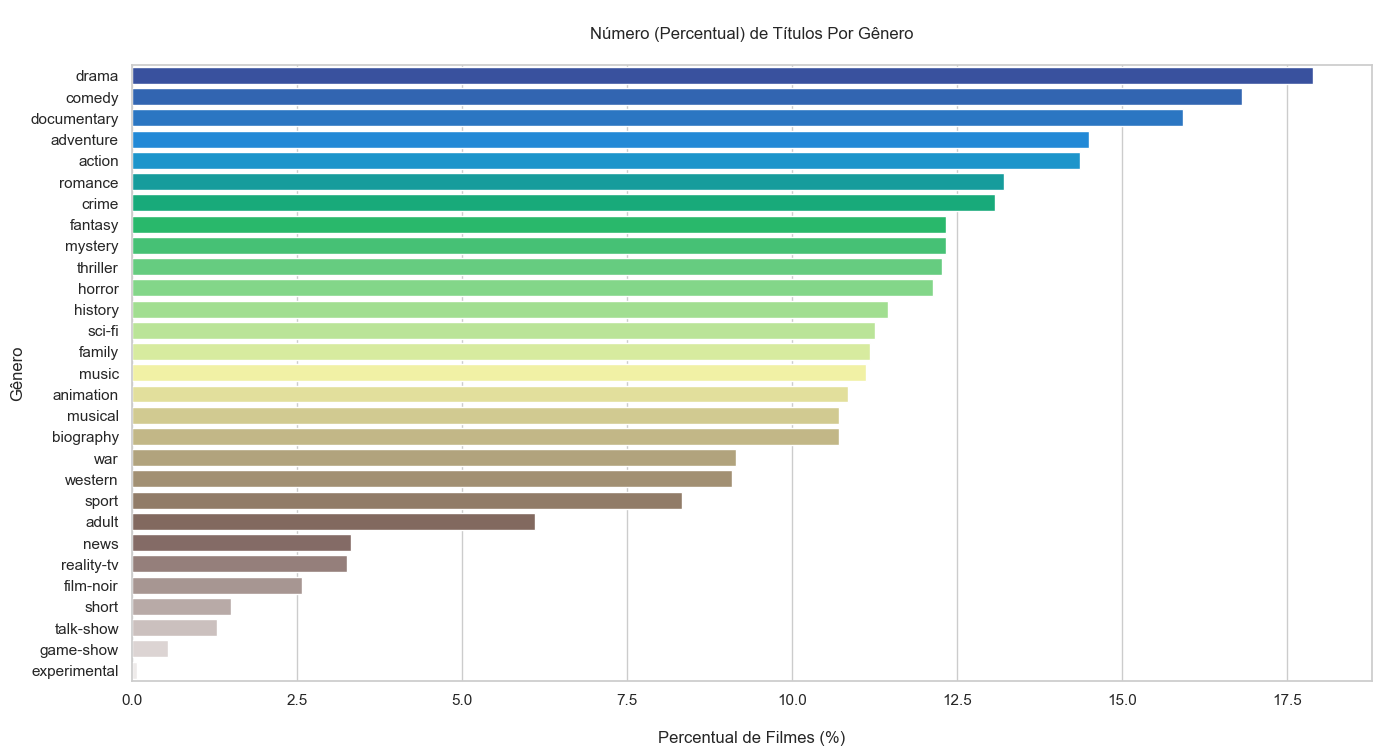

In [ ]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [ ]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres 
              FROM ratings 
              JOIN titles 
                ON ratings.title_id = titles.title_id 
             WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [ ]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [ ]:
display(resultado3)

,rating,genres
0,5.3,Romance
1,5.2,"Documentary,News,Sport"
2,4.2,None
3,6.0,"Action,Adventure,Biography"
4,4.4,Drama
...,...,...
285280,5.8,Thriller
285281,6.4,"Drama,History"
285282,3.8,"Adventure,History,War"
285283,8.3,Drama


In [ ]:
# Função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [ ]:
generos_unicos = retorna_generos(resultado3)

In [ ]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [ ]:
genero_counts = []
genero_ratings = []

In [ ]:
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [ ]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [ ]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,29584,5.8
1,adult,4191,5.7
2,adventure,17937,6.0
3,animation,4937,6.6
4,biography,8815,7.0
5,comedy,70622,6.0
6,crime,24739,6.1
7,documentary,43519,7.3
8,drama,126803,6.4
9,family,11037,6.3


In [ ]:
# Drop do índice 18 (news)
# Não quero essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [ ]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

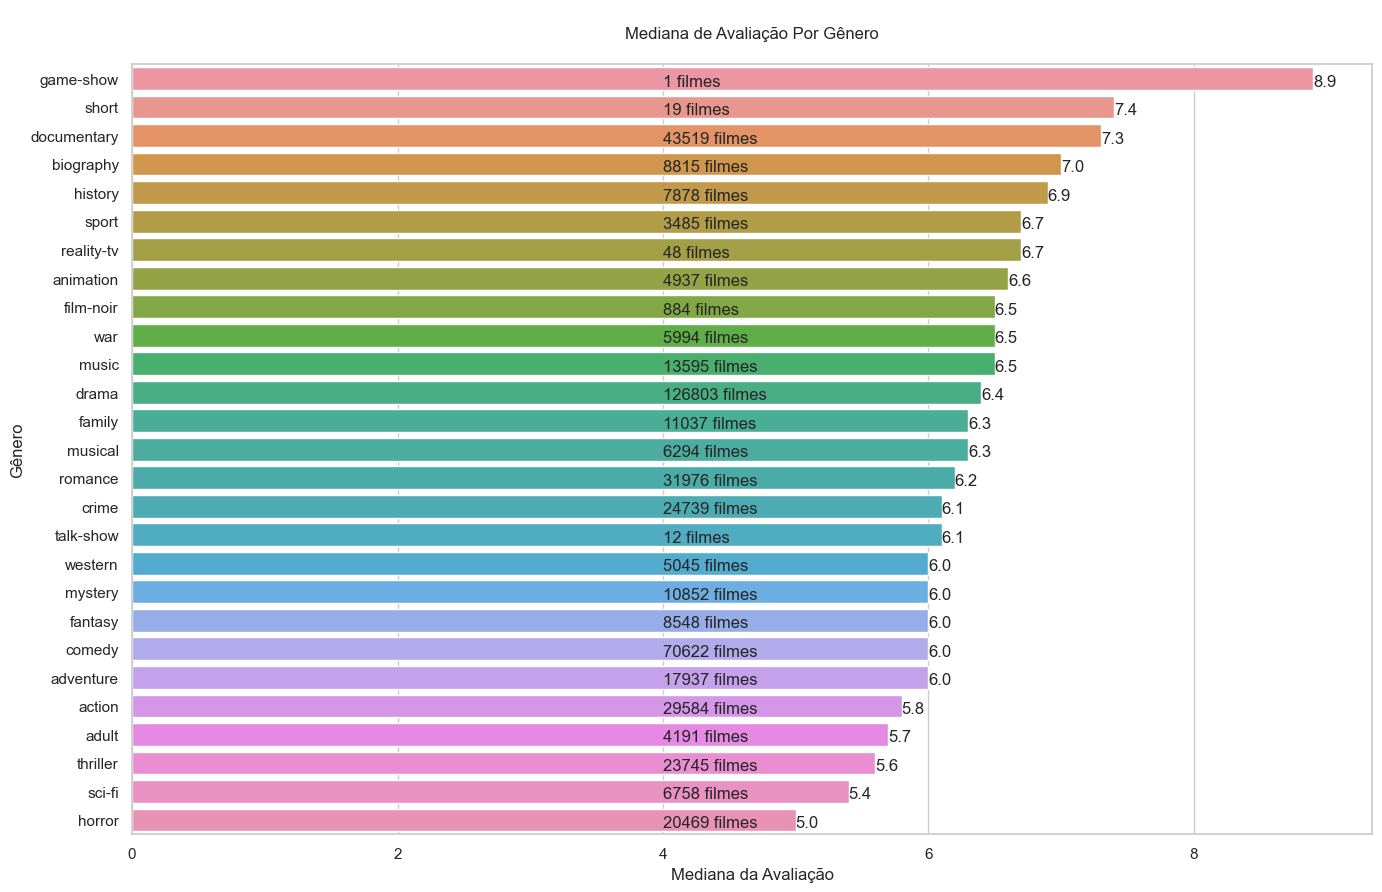

In [ ]:
# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [ ]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [ ]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [ ]:
display(resultado4)

,Rating,premiered
0,5.3,1894
1,5.2,1897
2,4.5,1897
3,3.9,1899
4,3.4,1899
...,...,...
285280,6.8,2022
285281,2.1,2022
285282,5.5,2022
285283,3.9,2022


In [ ]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [ ]:
type(ratings)

list

In [ ]:
ratings[1:10]

[4.85, 3.65, 5.85, 4.3, 3.3, 5.25, 5.3, 4.300000000000001, 3.1]

In [ ]:
anos = list(set(resultado4['premiered']))

In [ ]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

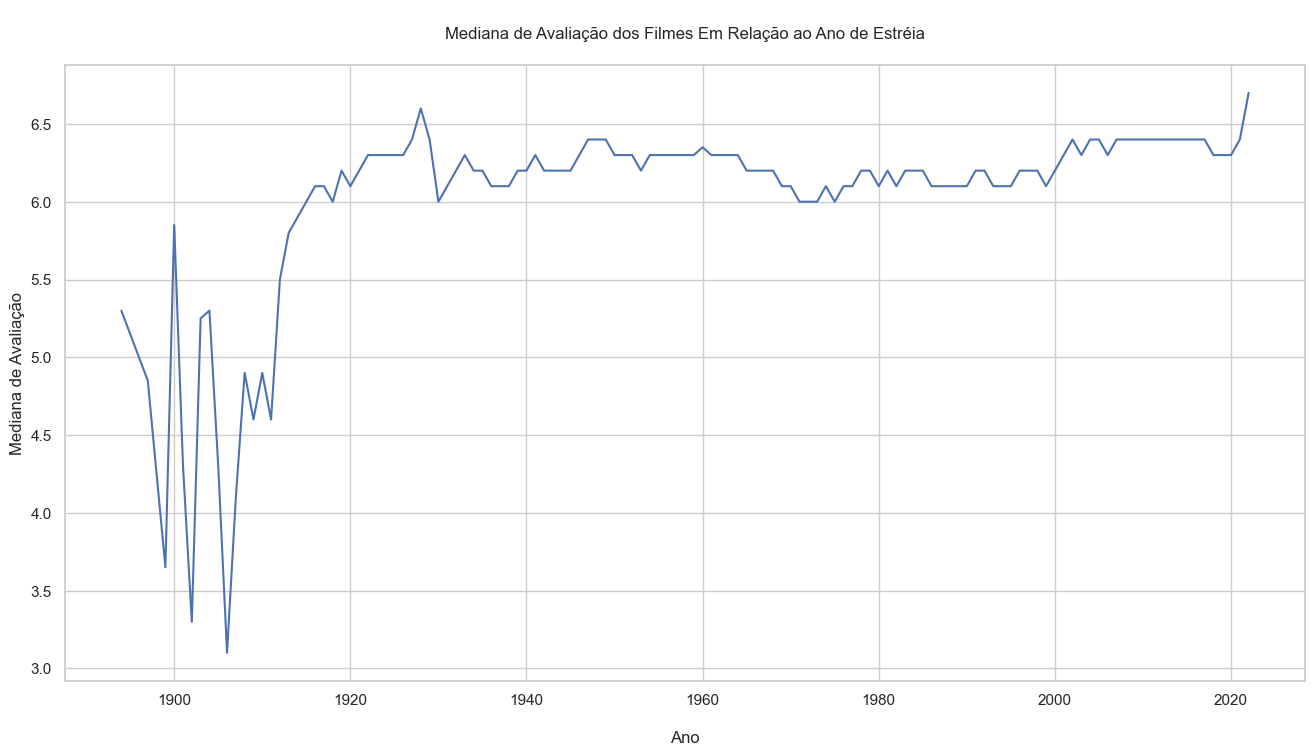

In [ ]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [ ]:
consulta5 = '''SELECT genres FROM titles ''' 

In [ ]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [ ]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9525739,"Action,Drama,Family"
9525740,"Action,Drama,Family"
9525741,"Action,Drama,Family"
9525742,Short


In [ ]:
generos_unicos = retorna_generos(resultado5)

In [ ]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [ ]:
# Fazendo a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [ ]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [ ]:
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

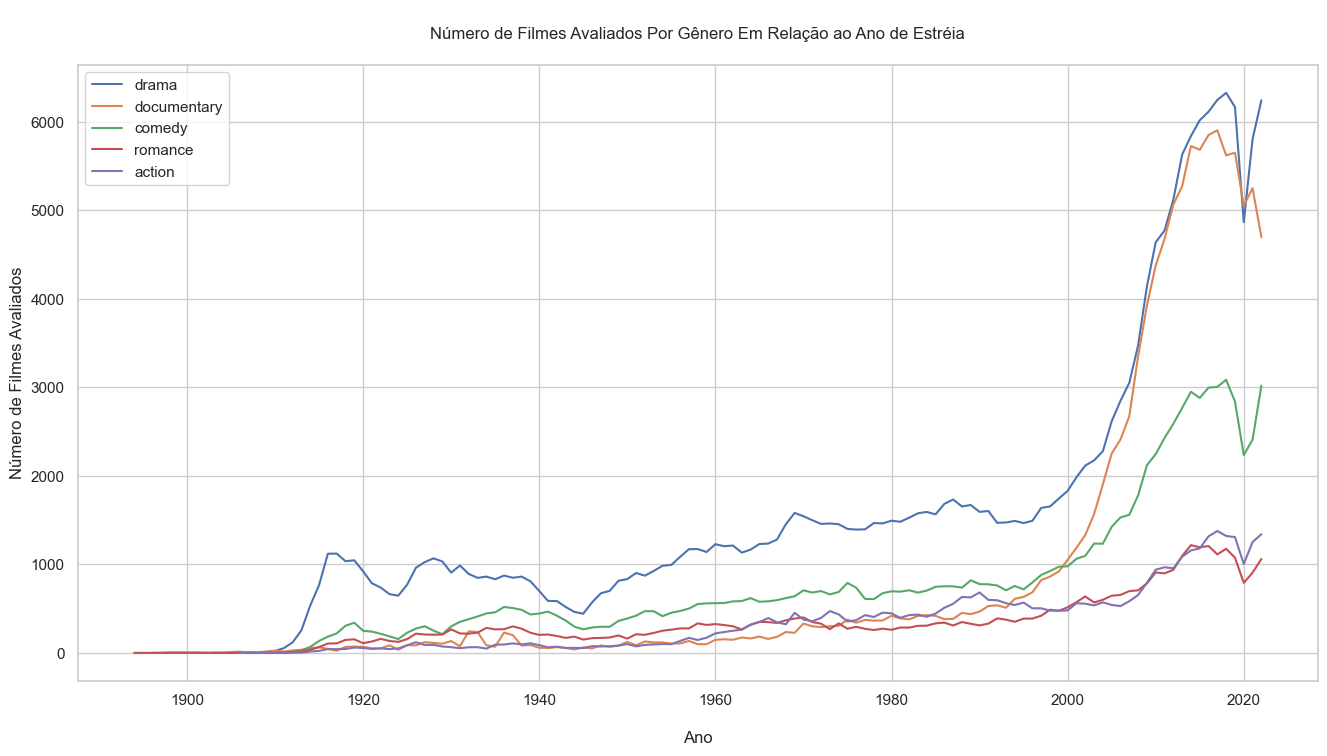

In [ ]:
# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Percentis e filme mais longo da história.

In [ ]:
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [ ]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [ ]:
display(resultado6)

,Runtime
0,45
1,100
2,100
3,70
4,90
...,...
399174,123
399175,57
399176,100
399177,116


In [ ]:
# Loop para cálculo dos percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 49.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 50.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 54.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 68.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [ ]:
# Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [ ]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [ ]:
resultado6

,Runtime,primary_title
0,59460,100


'Logistics' é o filme mais longo da história (até este momento), com 991 horas (59460 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.

## 7- Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero.

In [ ]:
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [ ]:
resultado7 = pd.read_sql_query(consulta7, conn)

In [ ]:
generos_unicos = retorna_generos(resultado7)

In [ ]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [ ]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [ ]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [ ]:
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [ ]:
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

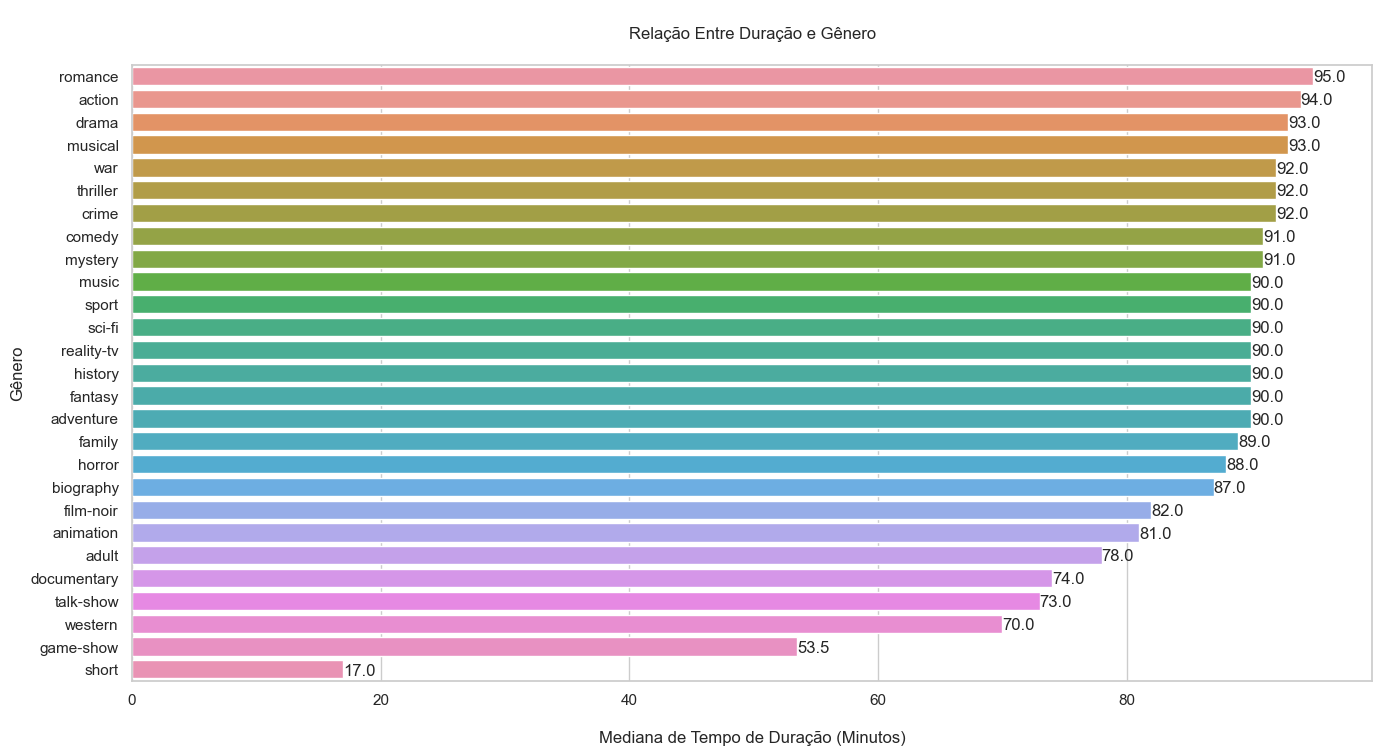

In [ ]:
# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [ ]:
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [ ]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [ ]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,8829
2,AF,113
3,AG,12
4,AL,1311
...,...,...
230,YUCS,152
231,ZA,13207
232,ZM,47
233,ZRCD,2


In [ ]:
resultado8.shape

(235, 2)

In [ ]:
resultado8.shape[0]

235

In [ ]:
nomes_paises = []
contagem = []

In [ ]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [ ]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [ ]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [ ]:
df_filmes_paises.head(10)

,country,Movie_Count
200,United States,324506
66,United Kingdom,163739
97,Japan,95409
90,India,93226
64,France,88185
32,Canada,85561
48,Germany,76266
59,Spain,68823
94,Italy,68389
26,Brazil,67568


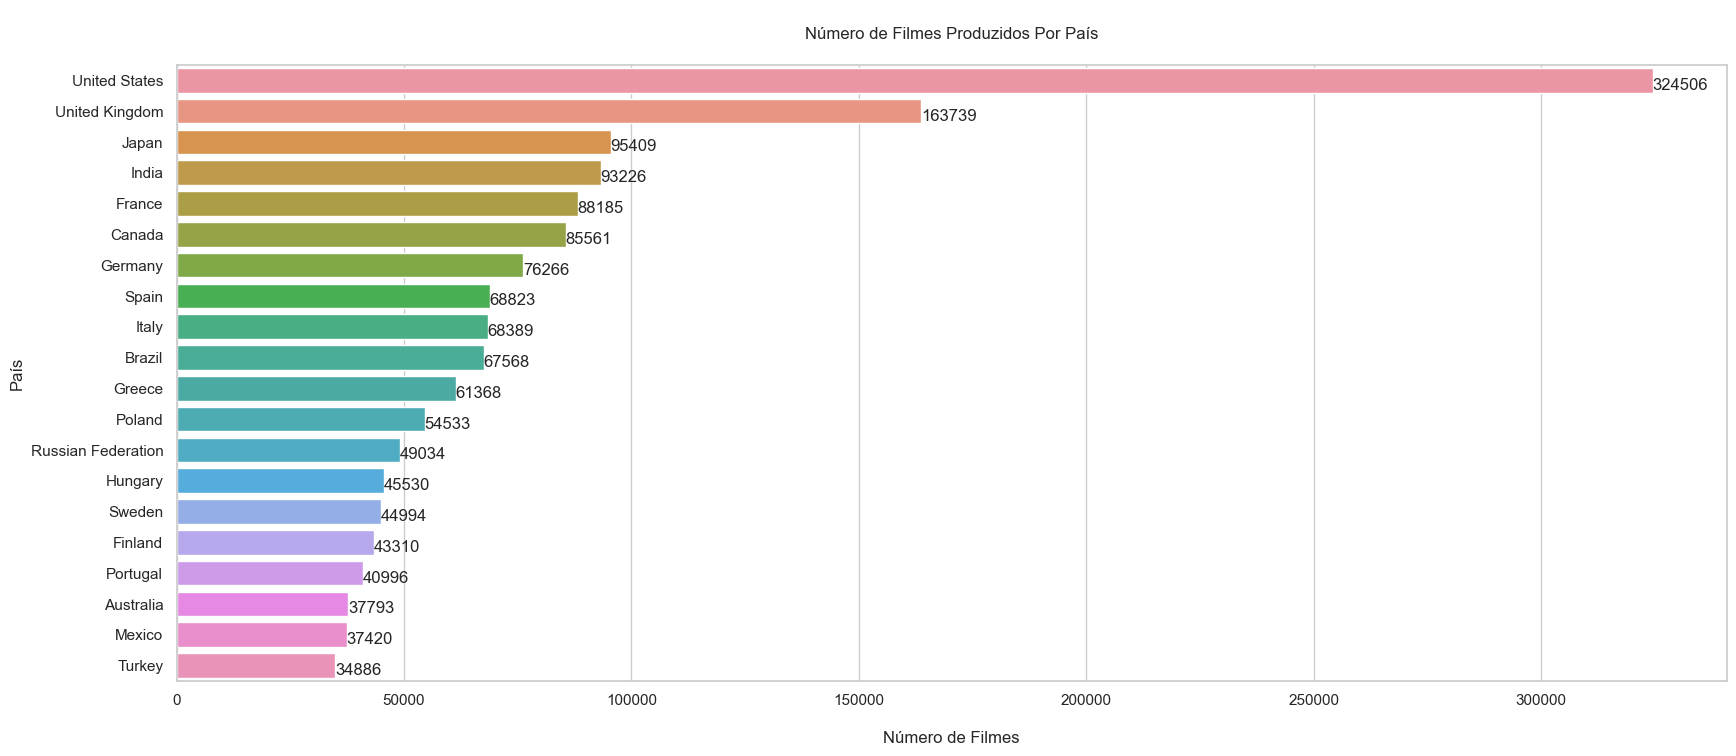

In [ ]:
# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9- Quais São os Top 10 Melhores Filmes?

Top 10 filmes com melhor avaliação e mais de 25 mil votos.

In [ ]:
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [ ]:
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [ ]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather: Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


## 10- Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos.

In [ ]:
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [ ]:
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [ ]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Angels Apocalypse,"Action,Fantasy,Sci-Fi",1.4
5,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
6,The Cost of Deception,"Action,Crime,Drama",1.5
7,Manos: The Hands of Fate,Horror,1.6
8,Justin Bieber: Never Say Never,"Documentary,Music",1.6
9,Code Name: K.O.Z.,"Crime,Mystery",1.7
